# 4. Two Variable Functions

In [1]:
import numpy as np

from scipy.linalg import eig
from scipy.fft import fft2, ifft2

import matplotlib.pyplot as plt

In [2]:
def FourierD(N):
    row = np.arange(N)[:, None]
    col = np.arange(N)[None, :]
    I  = np.eye(N)
    Ic = np.ones((N, N)) - I
    
    x = 2 * np.pi * row / N
    h = (x[1] - x[0])[0]
    
    if N % 2 == 0:
        center = - (N**2 + 2) / 12
        D1 = Ic * 0.5 * (-1)**(row + col) / np.tan(0.5 * ((row - col) * h) + I)
        D2 = Ic * 0.5 * (-1)**(row + col + 1) / np.sin(0.5 * ((row - col) * h) + I)**2 + center * I
    else:
        center = (1 - N**2) / 12
        D1 = Ic * 0.5 * (-1)**(row + col) / np.sin(0.5 * ((row - col) * h) + I)
        D2 = Ic * 0.5 * (-1)**(row + col + 1) / (np.sin(0.5 * ((row - col) * h)) * np.tan(0.5 * ((row - col) * h)) + I) + center * I
    return x, D1, D2

def ChebyshevD(N):
    row = np.arange(N + 1)[:, None]
    col = np.arange(N + 1)[None, :]
    x  = np.cos(np.pi * row / N)
    c  = ((1 + (col % N == 0)) * (-1) ** col).T
    X  = np.ones(N + 1) * x
    dX = X - X.T
    D  = c @ (1 / c.T) / (dX + np.eye(N + 1))
    D1 = D - np.diag(np.sum(D, axis=1))
    D2 = D1@D1
    return x, D1, D2

def aliased_index(k, N):
    return k - N * (k >= (N + 1)//2)

## 4.1. Lexicographic Ordering and the Kronecker Product

The differentiation matrices can be easily extended to functions of two variables by "unwrapping" the 2D grid functions into a column vectors of the form

$$f_\text{Lexi} = (f_{0,0}, f_{0,1}, \dots, f_{0,N_y-1}, f_{0,N_y}, \; f_{1,0}, f_{1,1}, \dots, f_{N_x-1,N_y-1}, f_{N_x-1,N_y},  \; f_{N_x,0}, f_{N_x,1}, \dots, f_{N_x,N_y-1}, f_{N_x,N_y})^T$$

which is equivalent to expressing the original grid function $f_{i,j}$ in terms of the super-index $I = (N_y + 1) \, i + j$. This ordering is called "lexicographic" ordering, as it reads the components of $f_{i,j}$ from left to right and from top to bottom. The derivative operators that act on these grid functions can be easily constructed by the Kronecker product:

$$D_x = D_{N_x} \, \otimes\, I_{N_y}\, ,$$
$$D_y = I_{N_x} \, \otimes\, D_{N_y}\, .$$

In the cell below, we test the operators on the function $f(x, y) = e^{\sin x + \sin y}$.

In [3]:
Nx = 31
Ny = 40
x_grid, D1x, D2x = FourierD(Nx)
y_grid, D1y, D2y = FourierD(Ny)

x_sq = x_grid @ np.ones((1, Ny))
y_sq = np.ones((Nx, 1)) @ y_grid.T
x    = x_sq.reshape((Nx * Ny, 1))
y    = y_sq.reshape((Nx * Ny, 1))

Dx = np.kron(D1x, np.eye(Ny))
Dy = np.kron(np.eye(Nx), D1y)

f   = np.exp(np.sin(x) + np.sin(y))
dxf = np.cos(x) * f
dyf = np.cos(y) * f

print('Derivative in x:', np.allclose(Dx @ f, dxf))
print('Derivative in y:', np.allclose(Dy @ f, dyf))

Derivative in x: True
Derivative in y: True


## 4.2 FFT Derivatives in 2 Dimensions

If we want to use FFT derivatives instead, there is no need for any reshaping of the matrices. We only need to multiply the correct frequencies by the 2-dimensional FFT. We must pay attention to aliasing and the Nyquist frequency, as we did in the 1D case. Otherwise, the derivatives will be wrong.

In [4]:
f_sq   = np.exp(np.sin(x_sq) + np.sin(y_sq))
dxf_sq = np.cos(x_sq) * f_sq
dyf_sq = np.cos(y_sq) * f_sq

wx = aliased_index(np.arange(Nx)[:, None], Nx)
wy = aliased_index(np.arange(Ny)[None, :], Ny)

wx[Nx//2, :] = 0    #Here we kill the derivative of the Nyquist mode.
wy[:, Ny//2] = 0    #This is equivalent to Trefethen's trick in page 23.

FFT_dxf = ifft2(1j * wx * fft2(f_sq)).real
FFT_dyf = ifft2(1j * wy * fft2(f_sq)).real

print('Derivative in x:', np.allclose(FFT_dxf, dxf_sq))
print('Derivative in y:', np.allclose(FFT_dyf, dyf_sq))

Derivative in x: True
Derivative in y: True


## 4.3. Polar Coordinates

Here we will compute the eigenvalues of the 2D Helmholtz equation in polar coordinates

$$(\nabla^2 + \lambda^2) \psi = 0\, , \quad \psi(r = 1, \theta) = 0\, .$$

The Laplace operator can be written explicitly as

$$ \nabla^2 = \frac{\partial^2}{\partial r^2} + \frac{1}{r} \frac{\partial}{\partial r} + \frac{1}{r^2} \frac{\partial^2}{\partial \theta^2} \, .$$

In this case, in order to impose regularity conditions at the coordinate singularity $r = 0$, as well as to avoid having an unnecessary clustering of grid points near $r = 0$, we will use the trick described by Trefethen. This trick extends the radial coordinate from -1 to 1, and imposes the identification

$$ \psi(r, \theta) \sim \psi(-r, \theta + \pi)\, . $$

Then, the contributions from $(r < 0)$ and $(r > 0)$ are added together in the Laplacion operator `Laplacian(N, M)`.

In [5]:
def Laplacian(N, M):
    r, D1r, D2r = ChebyshevD(N)
    t, D1t, D2t = FourierD(M)
    
    D1rp = D1r[1:N//2 + 1, 1:N//2 + 1]   # First  radial derivative, positive r
    D1rn = D1r[1:N//2 + 1, N-1:N//2:-1]  # First  radial derivative, negative r
    D2rp = D2r[1:N//2 + 1, 1:N//2 + 1]   # Second radial derivative, positive r
    D2rn = D2r[1:N//2 + 1, N-1:N//2:-1]  # Second radial derivative, negative r
    
    R  = np.diag(1/r[1:N//2 + 1, 0])
    IZ = np.hstack([np.eye(M//2), np.zeros((M//2, M//2))])
    ZI = np.hstack([np.zeros((M//2, M//2)), np.eye(M//2)])
    T1 = np.vstack([IZ, ZI])  # This is actually np.eye(M)
    T2 = np.vstack([ZI, IZ])
    
    L = np.kron(D2rp + R @ D1rp, T1) + np.kron(D2rn + R @ D1rn, T2) + np.kron(R @ R, D2t)  # Laplacian operator

    return r[1:N//2 + 1], t, L

We can use the discretized Laplacian to find the vibrational modes of a circular drum membrane. The eigenmodes can then be ordered by their number of nodes, both in the $r$ and $\theta$ coordinates. In this case, the code below only works for odd $N$ and even $M$.

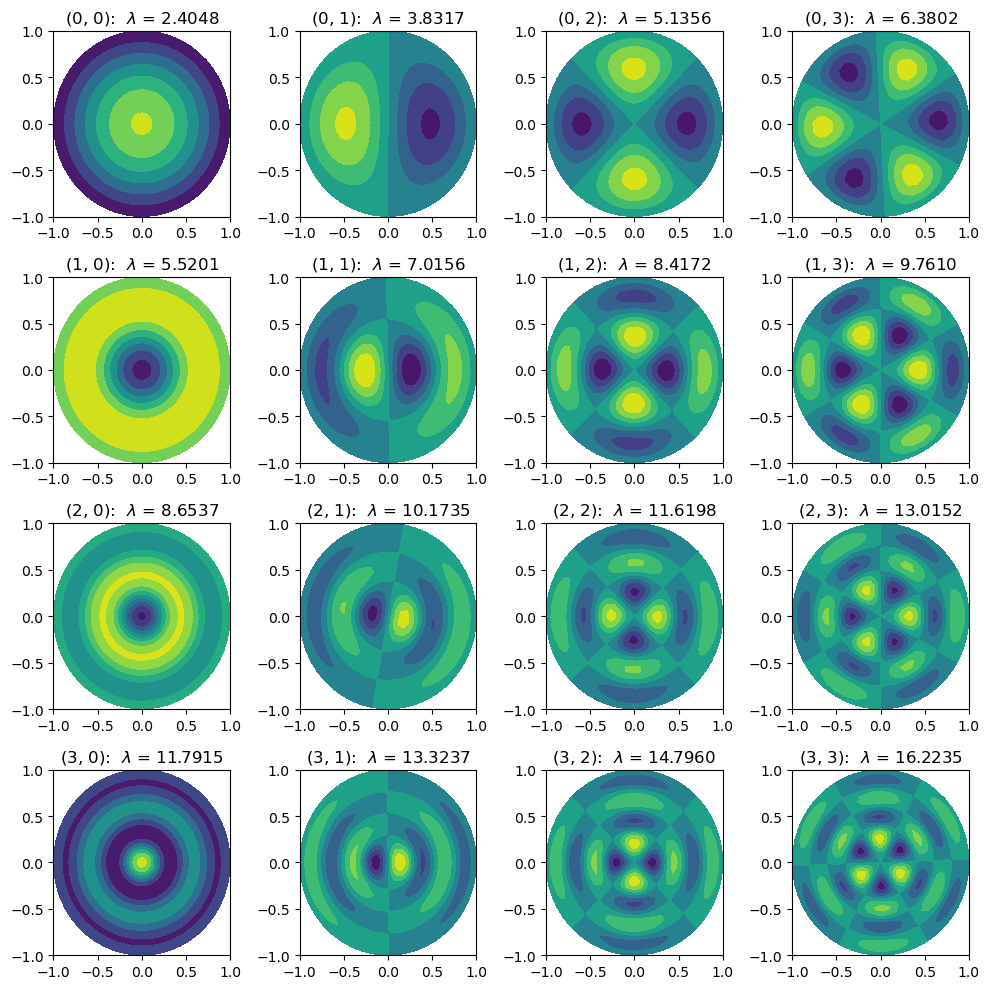

In [6]:
N = 51 # Number of points in Chebyshev radial grid. This has to be odd!
M = 50 # Number of points in Fourier angular grid. This has to be even!
n = 4  # Number of modes per side of the grid

r, t, L = Laplacian(N,M)
lam2, V = eig(-L)

# Sort the eigenvalues and reshape
indices = np.argsort(lam2.real)
lam     = np.sqrt(lam2.real[indices])
V       = V[:, indices].reshape(N//2, M, (N//2)*M).real

# Prepare the full r and theta grids in matrix form.
rr = np.ones((M + 1, 1)) @ np.vstack([1, r, 0]).T
tt = np.vstack([t, 2*np.pi]) @ np.ones((1, N//2 + 2))

# Complete the theta angle by identifying psi(r, 2*pi) = psi(r, 0).
V = np.hstack([V, V[:, [0], :]])

# Reintroduce the boundary points as psi(1, theta) = 0.
V = np.vstack([np.zeros((1, M + 1, (N//2)*M)), V])

# Add point at r=0 as the average value of the neighboring ones, for nicer plots.
V = np.vstack([V, np.mean(V[[-1], :, :], axis = 1) * np.ones((1, M + 1, (N//2)*M))]) 

# Index the solutions by counting the nodes in the r and theta directions.
r_nodes   = np.sum((V[2:-1, [1], :] * V[1:-2, [1], :]) < 0, axis = 0).flatten()
t_nodes   = np.sum((V[[1], 1:, :] * V[[1], :-1, :]) < 0, axis = 1).flatten() // 2
all_nodes = list(zip(r_nodes, t_nodes))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(n, n, figsize = (10, 10));
plt.rc('font', size = 10)

for i in range(n):
    for j in range(n):
        position = all_nodes.index((i, j))
        ax[i, j].contourf(rr.T * np.cos(tt.T), rr.T * np.sin(tt.T), V[:, :, position])
        ax[i, j].set_title(f'({i}, {j}):  ' + r'$\lambda$ =' + f' {lam[position]:.4f}')
        ax[i, j].set_xlim(-1,1)
        ax[i, j].set_ylim(-1,1)
        
plt.tight_layout()
################################################################################